<a href="https://colab.research.google.com/github/ChhaSahil/Cust_Churn_Prediction/blob/main/Customer_Churn_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

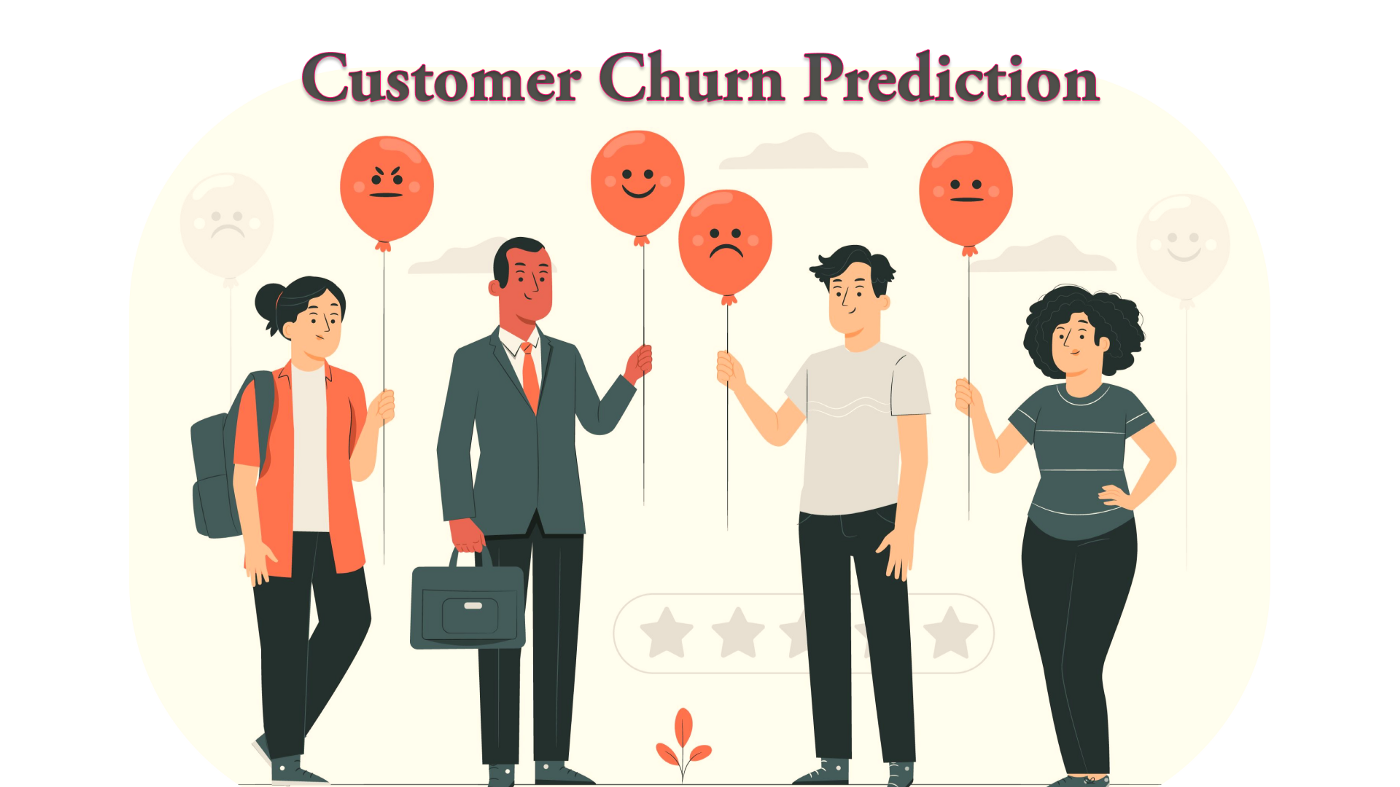

###Importing Necessary Libraries & Data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.metrics import precision_score,recall_score,roc_auc_score,cohen_kappa_score

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import ADASYN
from xgboost import XGBClassifier

In [ ]:
df = pd.read_csv('/content/Bank Customer Churn Prediction.csv')

We have 1 for churned customers and 0 for not churned customers

In [ ]:
df.head()

,customer_id,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
0,15634602,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,15647311,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,15619304,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,15701354,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,15737888,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [ ]:
df.shape

(10000, 12)

Hence we have 10000 rows and 12 columns

In [ ]:
df.isnull().sum()

customer_id         0
credit_score        0
country             0
gender              0
age                 0
tenure              0
balance             0
products_number     0
credit_card         0
active_member       0
estimated_salary    0
churn               0
dtype: int64

Hence we have no null values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customer_id       10000 non-null  int64  
 1   credit_score      10000 non-null  int64  
 2   country           10000 non-null  object 
 3   gender            10000 non-null  object 
 4   age               10000 non-null  int64  
 5   tenure            10000 non-null  int64  
 6   balance           10000 non-null  float64
 7   products_number   10000 non-null  int64  
 8   credit_card       10000 non-null  int64  
 9   active_member     10000 non-null  int64  
 10  estimated_salary  10000 non-null  float64
 11  churn             10000 non-null  int64  
dtypes: float64(2), int64(8), object(2)
memory usage: 937.6+ KB


In [ ]:
df.describe()

,customer_id,credit_score,age,tenure,balance,products_number,credit_card,active_member,estimated_salary,churn
count,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,1.569094e+07,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,7.193619e+04,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,1.556570e+07,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,1.562853e+07,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,1.569074e+07,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,1.575323e+07,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,1.581569e+07,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


<ipython-input-8-4d7dec473b71>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(),annot = True,cmap = 'YlGnBu')


<Axes: >

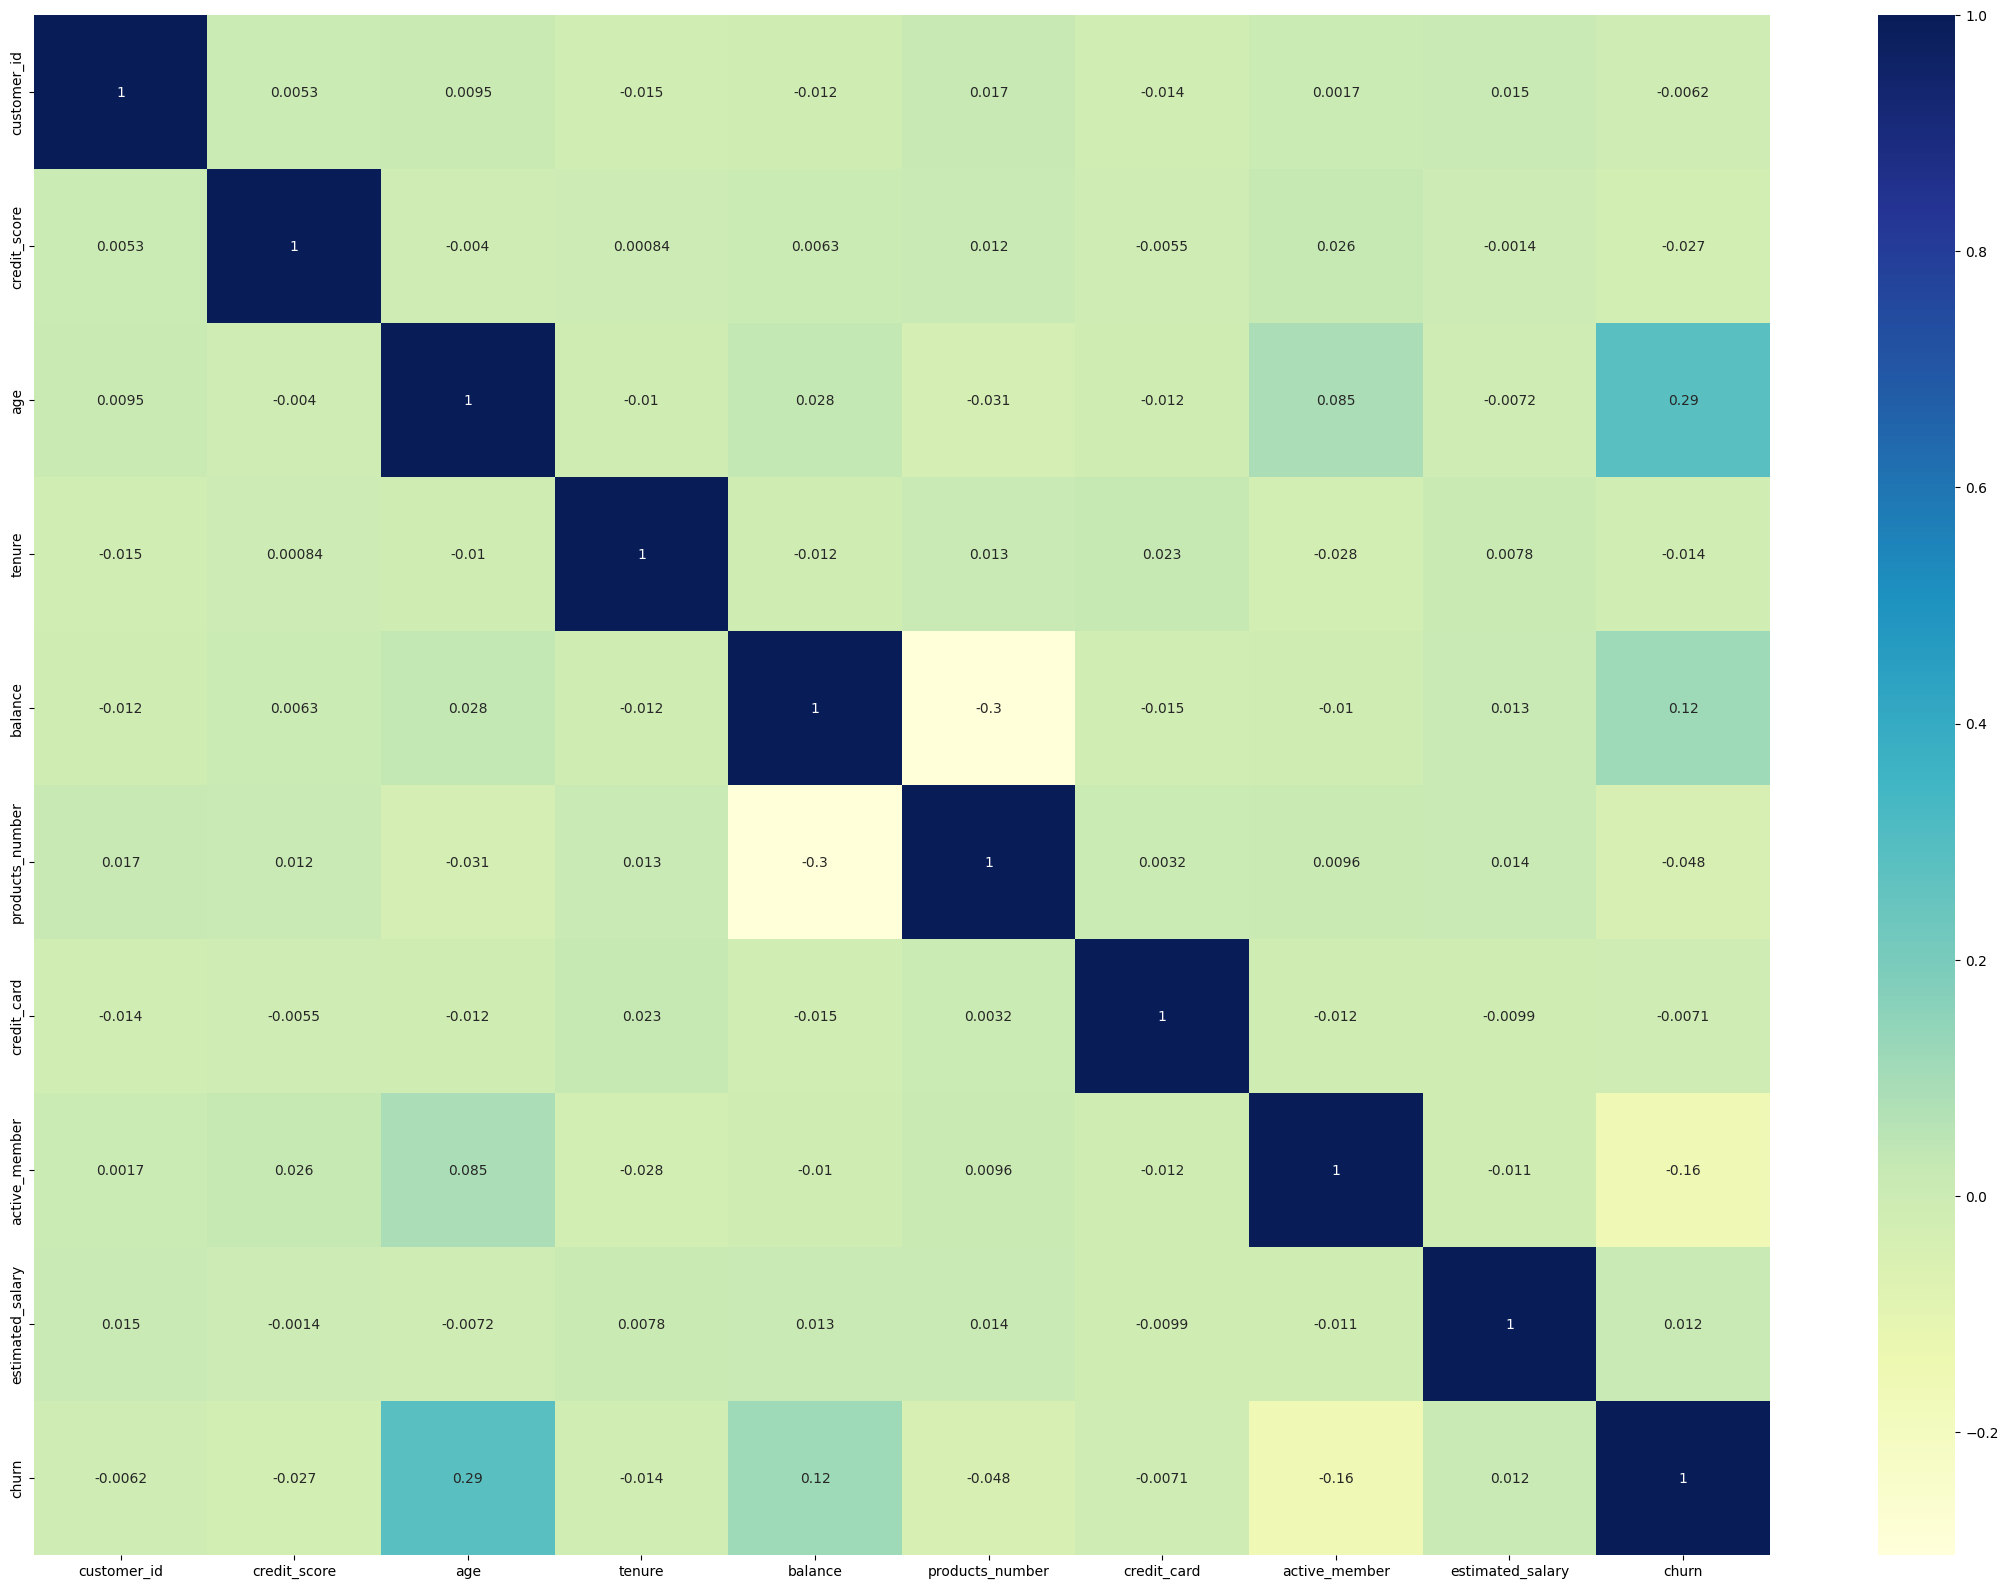

In [ ]:
plt.figure(figsize = (28,20))
sns.heatmap(df.corr(),annot = True,cmap = 'YlGnBu')

Text(0.5, 1.0, 'Number of Churned vs Non Churned Customers')

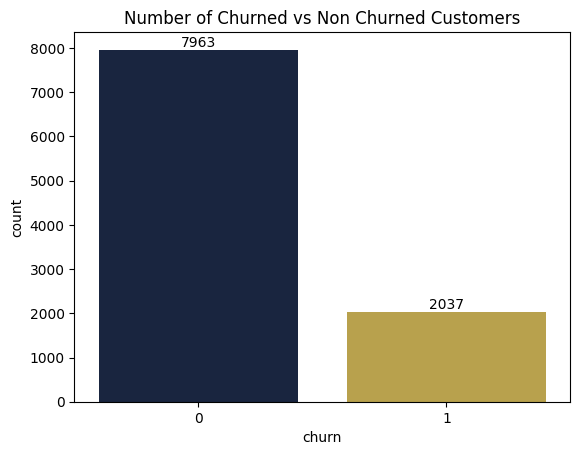

In [ ]:
ax = sns.countplot(data= df,x=df.churn,palette=['#132345',"#CAAB3B"])
for labels in ax.containers:
  ax.bar_label(labels)
plt.title('Number of Churned vs Non Churned Customers')

Hence our data is imbalanced

Let's split our data into churned and not churned customers

In [ ]:
data_churn = df[df['churn']==1]
data_nc = df[df['churn']==0]

Now we will look at the distribution of the data for both the categories

In [ ]:
def plot_pdf(df,x,ax,xlabel,title,color):
  data = df[x]
  loc = data.mean()
  scale = data.std()
  pdf = stats.norm.pdf(data,loc=loc,scale=scale)

  sns.lineplot(x=data,y = pdf,color = color, ax=ax)
  ax.set_facecolor('black')
  ax.grid(which = 'major', linewidth = '0.2', color = 'white')
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel('Probability Density')

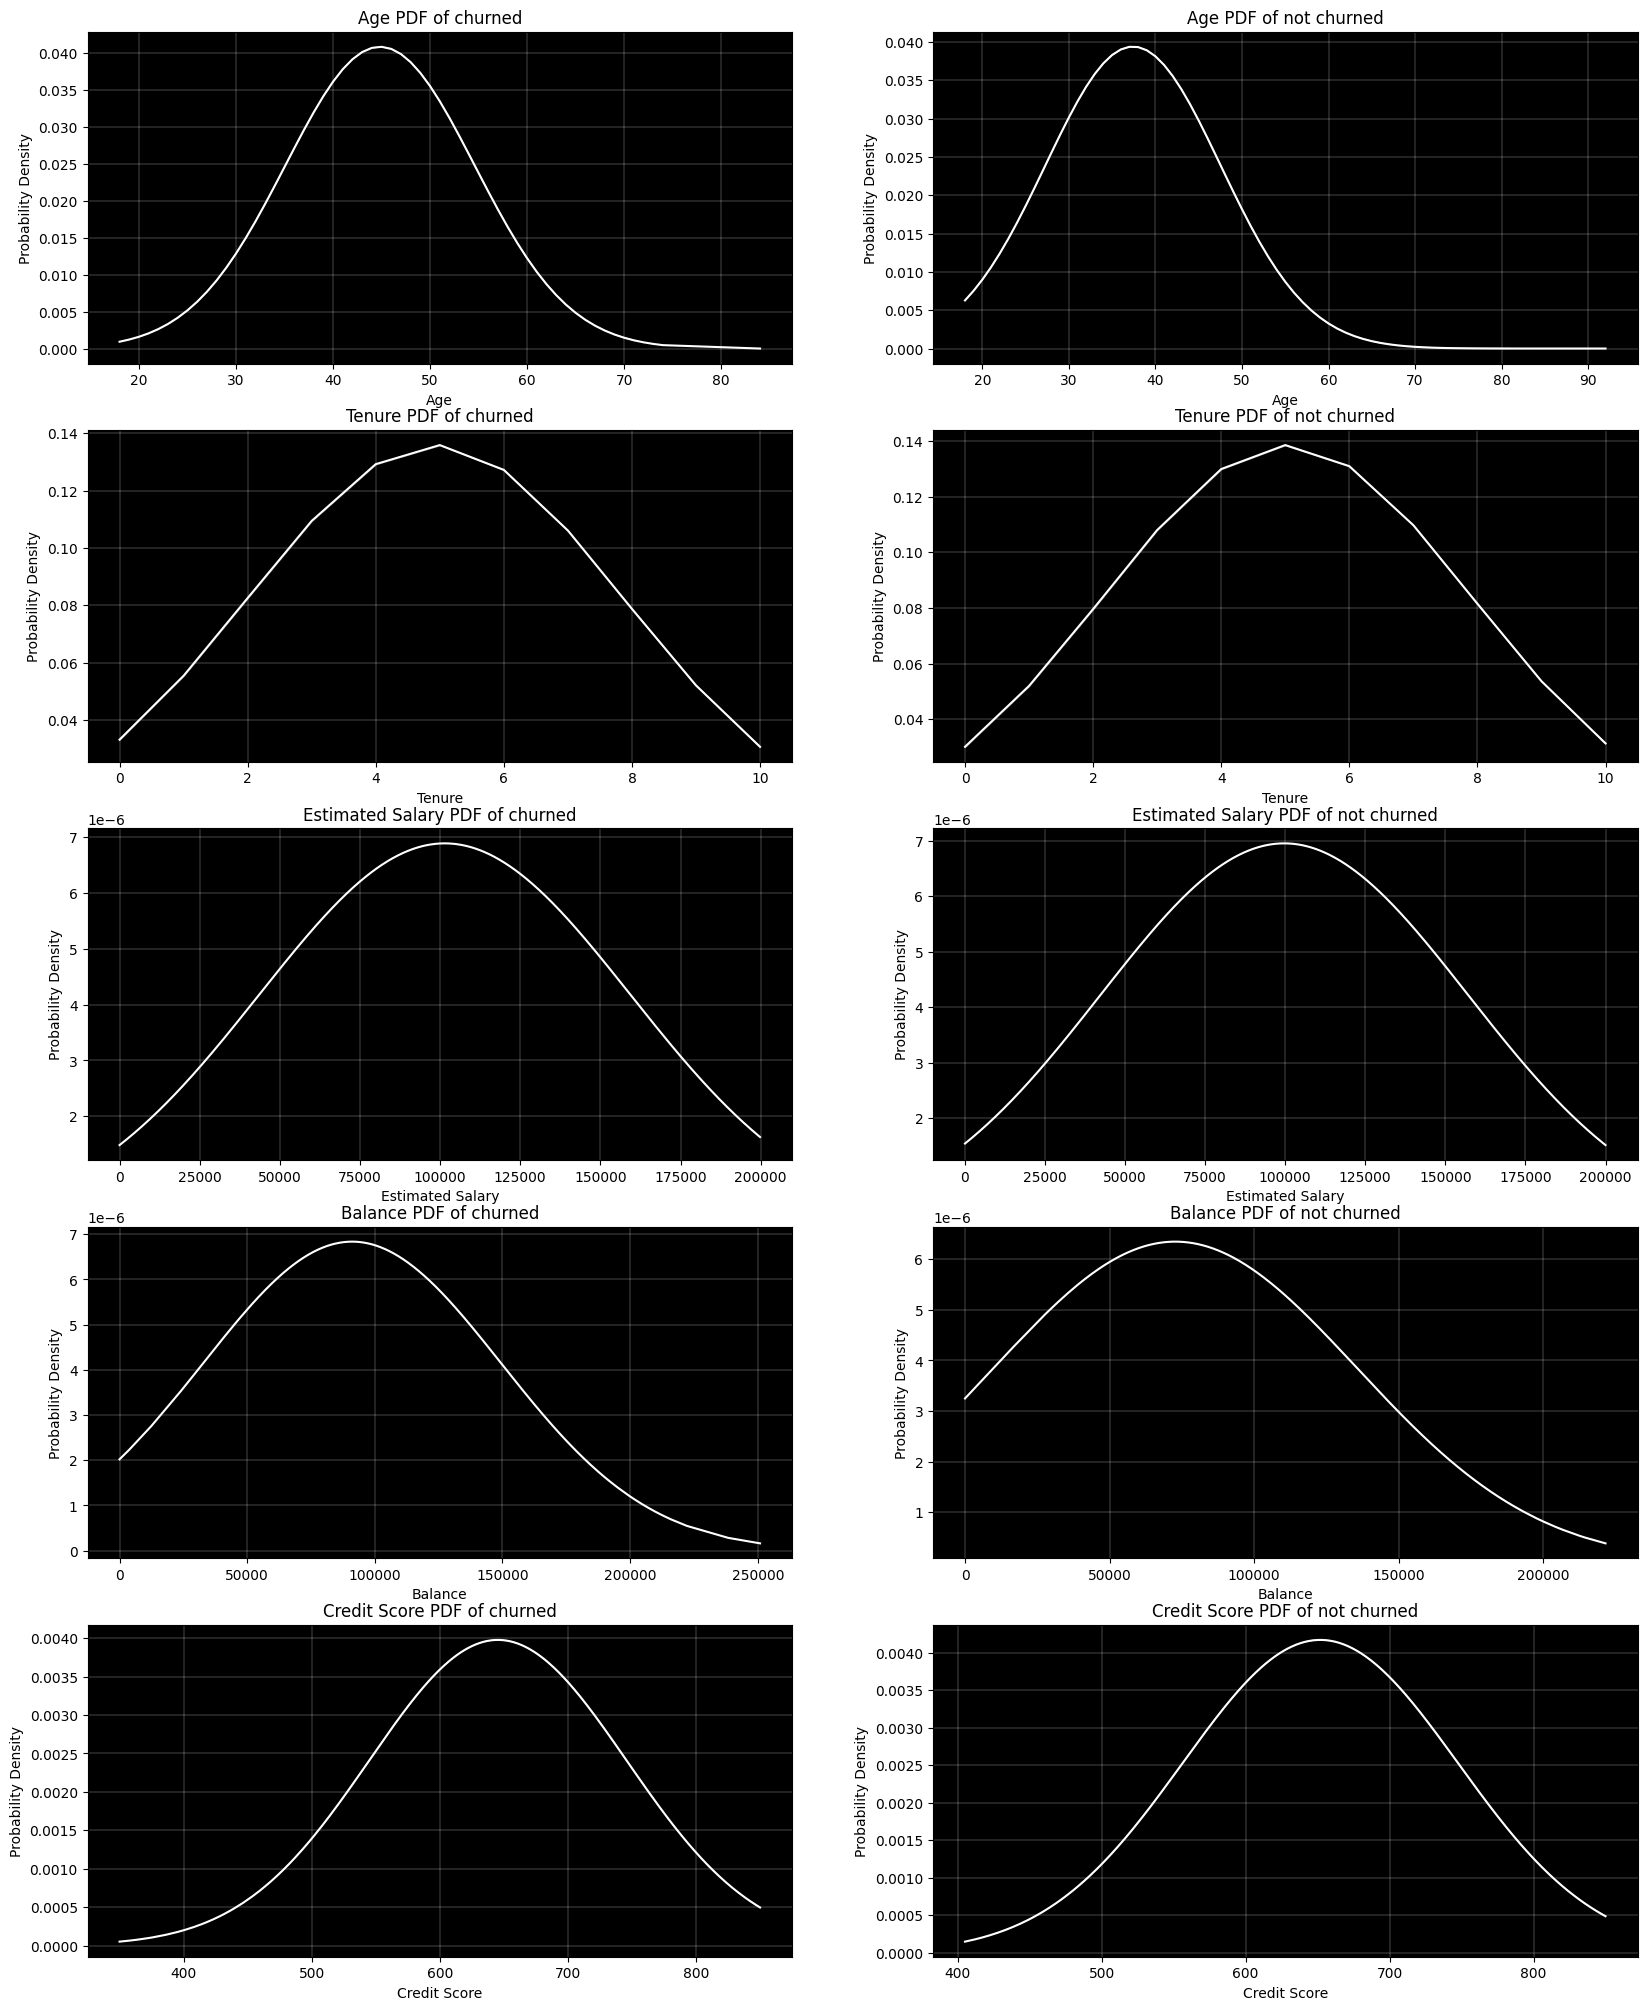

In [ ]:
fig, ((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8),(ax9,ax10)) = plt.subplots(5,2, figsize = (20,25))

plot_pdf(data_churn,'age',ax1,'Age','Age PDF of churned','white')
plot_pdf(data_nc,'age',ax2,'Age','Age PDF of not churned','white')
plot_pdf(data_churn,'tenure',ax3,'Tenure','Tenure PDF of churned','white')
plot_pdf(data_nc,'tenure',ax4,'Tenure','Tenure PDF of not churned','white')
plot_pdf(data_churn,'estimated_salary',ax5,'Estimated Salary','Estimated Salary PDF of churned','white')
plot_pdf(data_nc,'estimated_salary',ax6,'Estimated Salary','Estimated Salary PDF of not churned','white')
plot_pdf(data_churn,'balance',ax7,'Balance','Balance PDF of churned','white')
plot_pdf(data_nc,'balance',ax8,'Balance','Balance PDF of not churned','white')
plot_pdf(data_churn,'credit_score',ax9,'Credit Score','Credit Score PDF of churned','white')
plot_pdf(data_nc,'credit_score',ax10,'Credit Score','Credit Score PDF of not churned','white')

Hence the distribution of tenure, estimated salary, credit score and balance is similar for both the categories

Moreover we can get the following insights from the above PDFs:<br>
1. Among the churn customers we have more customers of age between 40-50 years. While in case of non churned customers we have more customers of age between 35-40 years.
2. Customers with Credit Score of less than 400 are under churned category.

### Now let's do some univariate and multivariate analysis

Text(0.5, 1.0, 'Number of Churned vs Non Churned Customers Country Wise')

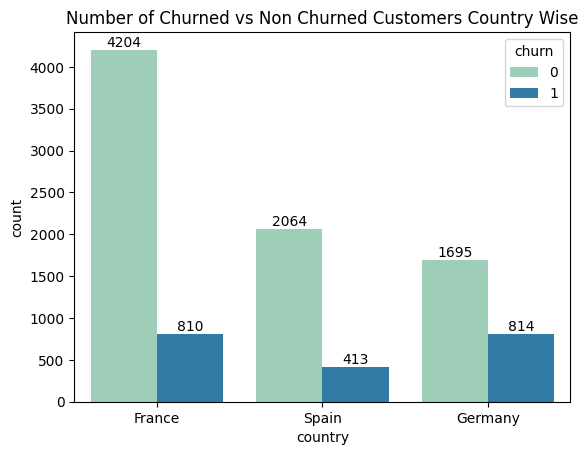

In [ ]:
ax = sns.countplot(data= df,x=df.country,hue = df.churn,palette='YlGnBu')
for labels in ax.containers:

  ax.bar_label(labels)
plt.title('Number of Churned vs Non Churned Customers Country Wise')

In [ ]:
df.country.value_counts()

France     5014
Germany    2509
Spain      2477
Name: country, dtype: int64

In [ ]:
print('Churn Rate Country Wise---')
print('France - ',round(810/5014,2))
print('Germany - ',round(814/1695,2))
print('Spain - ',round(413/2064,2))

Churn Rate Country Wise---
France -  0.16
Germany -  0.48
Spain -  0.2


Hence Germany has a higher churn rate than the other countries.

Text(0.5, 1.0, '% of Male and Female in churned Customers')

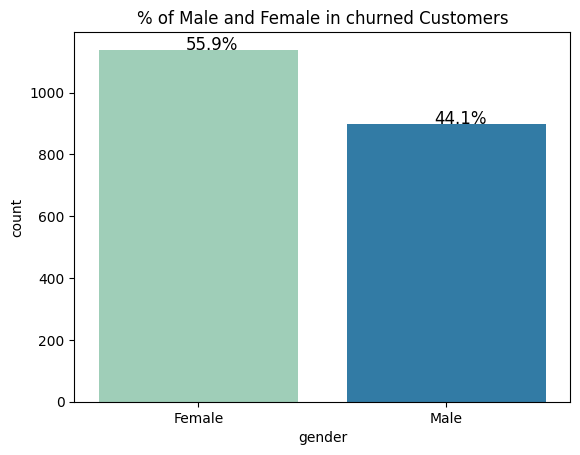

In [ ]:
ax = sns.countplot(data= data_churn,x=data_churn.gender,palette='YlGnBu')
total = len(data_churn)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height()/total)
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(percentage, (x, y), size = 12)
plt.title('% of Male and Female in churned Customers')

Hence we have more number of female churned customers.

In [ ]:
data_nc.gender.value_counts()

Male      4559
Female    3404
Name: gender, dtype: int64

In [ ]:
df.gender.value_counts()[::-1]

Female    4543
Male      5457
Name: gender, dtype: int64

[3404.0, 4559.0, 1139.0, 898.0]


Text(0.5, 1.0, 'Male vs Female Churn Rate ')

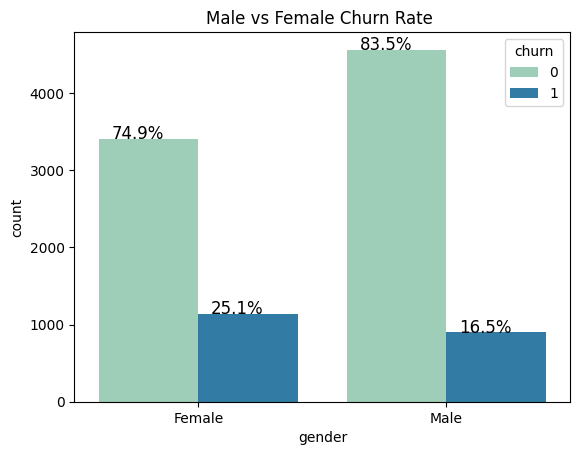

In [ ]:
ax = sns.countplot(data= df,x=df.gender,hue=df.churn,palette='YlGnBu')

a = [p.get_height() for p in ax.patches]
print(a)
patch = [p for p in ax.patches]
for i in range(2):
        total = df.gender.value_counts()[::-1].values[i]
        for j in range(2):
            percentage = '{:.1f}%'.format(100 * a[(j*2 + i)]/total)
            x = patch[(j*2 + i)].get_x() + patch[(j*2 + i)].get_width() / 2 - 0.15
            y = patch[(j*2 + i)].get_y() + patch[(j*2 + i)].get_height()
            ax.annotate(percentage, (x, y), size = 12)

plt.title('Male vs Female Churn Rate ')

Now we can see tha 25% of our female customers have churned while 16% of the male customers have stopped using our services

In [ ]:
data_churn.country.value_counts()[1:].to_list()+data_churn.country.value_counts()[:1].to_list()

[810, 413, 814]

[460.0, 231.0, 448.0, 350.0, 182.0, 366.0]
[<matplotlib.patches.Rectangle object at 0x7cb096c3bb80>, <matplotlib.patches.Rectangle object at 0x7cb096c3bca0>, <matplotlib.patches.Rectangle object at 0x7cb098dd0430>, <matplotlib.patches.Rectangle object at 0x7cb098dd0850>, <matplotlib.patches.Rectangle object at 0x7cb096c3be20>, <matplotlib.patches.Rectangle object at 0x7cb098dd0c40>]
810
413
814


Text(0.5, 1.0, 'Male vs Female Churn Rate Country-Wise')

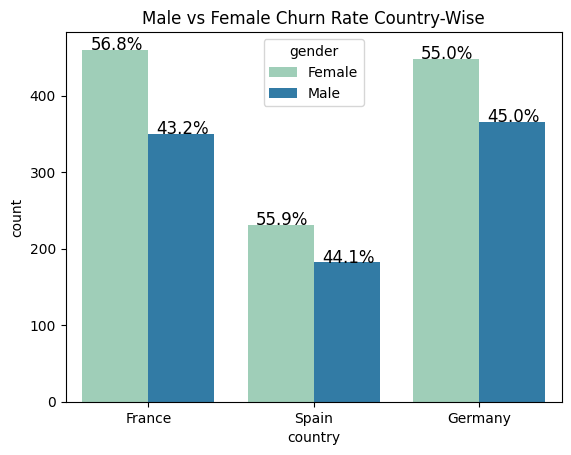

In [ ]:
ax = sns.countplot(data= data_churn,x=data_churn.country,hue = data_churn.gender,palette='YlGnBu')
a = [p.get_height() for p in ax.patches]
print(a)
patch = [p for p in ax.patches]
print(patch)
for i in range(3):
        total = (data_churn.country.value_counts()[1:].to_list()+data_churn.country.value_counts()[:1].to_list())[i]
        print(total)
        for j in range(2):
            percentage = '{:.1f}%'.format(100 * a[(j*3 + i)]/total)
            x = patch[(j*3 + i)].get_x() + patch[(j*3 + i)].get_width() / 2 - 0.15
            y = patch[(j*3 + i)].get_y() + patch[(j*3 + i)].get_height()
            ax.annotate(percentage, (x, y), size = 12)
plt.title('Male vs Female Churn Rate Country-Wise')

In all the 3 countries the ratio of male churned cutomers to female churned customers is nearly same.

[2332.0, 5631.0, 613.0, 1424.0]


Text(0.5, 1.0, 'Credit Card holders vs Non holders churn rate ')

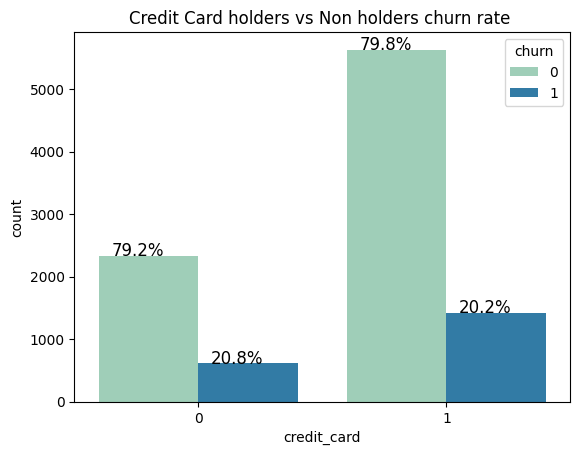

In [ ]:
ax = sns.countplot(data= df,x=df.credit_card,hue=df.churn,palette='YlGnBu')

a = [p.get_height() for p in ax.patches]
print(a)
patch = [p for p in ax.patches]
for i in range(2):
        total = df.credit_card.value_counts()[::-1].values[i]
        for j in range(2):
            percentage = '{:.1f}%'.format(100 * a[(j*2 + i)]/total)
            x = patch[(j*2 + i)].get_x() + patch[(j*2 + i)].get_width() / 2 - 0.15
            y = patch[(j*2 + i)].get_y() + patch[(j*2 + i)].get_height()
            ax.annotate(percentage, (x, y), size = 12)

plt.title('Credit Card holders vs Non holders churn rate ')

Hence we can say that holding a credit card or not does not indicate about churn.

[241.0, 135.0, 237.0, 569.0, 278.0, 577.0]
[<matplotlib.patches.Rectangle object at 0x7cb096ca92a0>, <matplotlib.patches.Rectangle object at 0x7cb096ca8df0>, <matplotlib.patches.Rectangle object at 0x7cb0974ebc10>, <matplotlib.patches.Rectangle object at 0x7cb096ca97b0>, <matplotlib.patches.Rectangle object at 0x7cb096ca8f70>, <matplotlib.patches.Rectangle object at 0x7cb096ca99f0>]
810
413
814


Text(0.5, 1.0, 'Male vs Female Churn Rate Country-Wise')

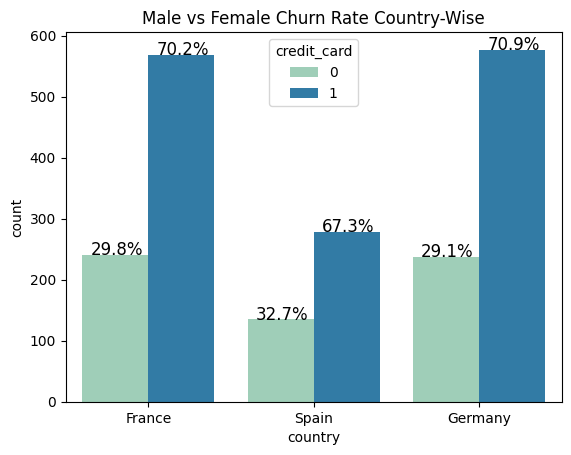

In [ ]:
ax = sns.countplot(data= data_churn,x=data_churn.country,hue = data_churn.credit_card,palette='YlGnBu')
a = [p.get_height() for p in ax.patches]
print(a)
patch = [p for p in ax.patches]
print(patch)
for i in range(3):
        total = (data_churn.country.value_counts()[1:].to_list()+data_churn.country.value_counts()[:1].to_list())[i]
        print(total)
        for j in range(2):
            percentage = '{:.1f}%'.format(100 * a[(j*3 + i)]/total)
            x = patch[(j*3 + i)].get_x() + patch[(j*3 + i)].get_width() / 2 - 0.15
            y = patch[(j*3 + i)].get_y() + patch[(j*3 + i)].get_height()
            ax.annotate(percentage, (x, y), size = 12)
plt.title('Male vs Female Churn Rate Country-Wise')

Hence people holding credit card are more amongst the churned customers

In [ ]:
data_nc.country.value_counts()['Spain']

2064

[621.0, 1230.0, 481.0, 1443.0, 2974.0, 1214.0]
[<matplotlib.patches.Rectangle object at 0x7cb0974d9b40>, <matplotlib.patches.Rectangle object at 0x7cb0974d8fa0>, <matplotlib.patches.Rectangle object at 0x7cb096c4a380>, <matplotlib.patches.Rectangle object at 0x7cb0974d9b10>, <matplotlib.patches.Rectangle object at 0x7cb0974d9690>, <matplotlib.patches.Rectangle object at 0x7cb0974da2c0>]
2064
4204
1695


Text(0.5, 1.0, 'Country-Wise % of non churned credit card holders and non holders')

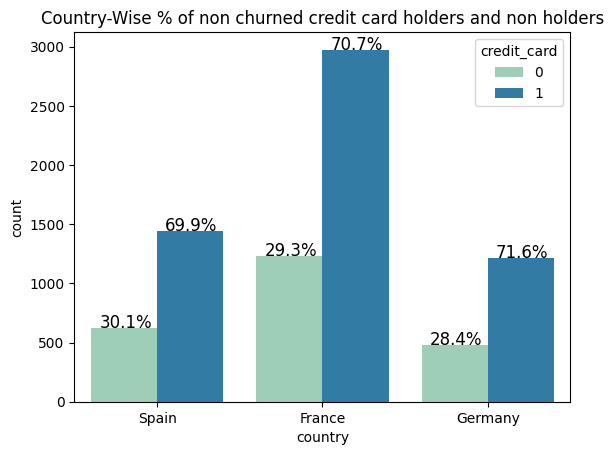

In [ ]:
ax = sns.countplot(data= data_nc,x=data_nc.country,hue = data_nc.credit_card,palette='YlGnBu')
a = [p.get_height() for p in ax.patches]
country = ['Spain','France','Germany']
print(a)
patch = [p for p in ax.patches]
print(patch)
for i,c in enumerate(country):
        total = data_nc.country.value_counts()[c]
        print(total)
        for j in range(2):
            percentage = '{:.1f}%'.format(100 * a[(j*3 + i)]/total)
            x = patch[(j*3 + i)].get_x() + patch[(j*3 + i)].get_width() / 2 - 0.15
            y = patch[(j*3 + i)].get_y() + patch[(j*3 + i)].get_height()
            ax.annotate(percentage, (x, y), size = 12)
plt.title('Country-Wise % of non churned credit card holders and non holders')

Text(0.5, 1.0, 'Male vs Female Churn Rate according to credit card holder')

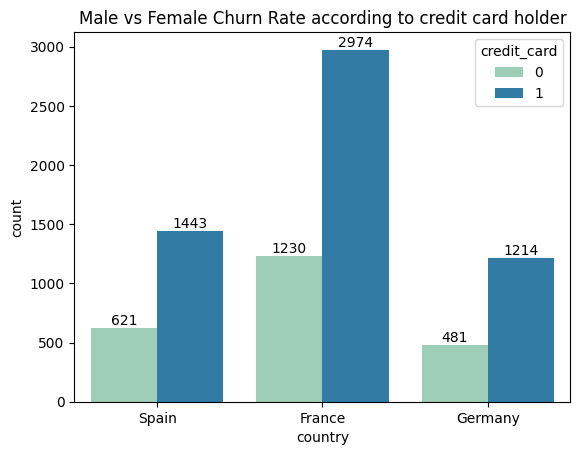

In [ ]:
ax = sns.countplot(data= data_nc,x=data_nc.country,hue = data_nc.credit_card,palette='YlGnBu')
for labels in ax.containers:
  ax.bar_label(labels)
plt.title('Male vs Female Churn Rate according to credit card holder')

Text(0.5, 1.0, 'Male vs Female Churn Rate according to Product taken from Bank')

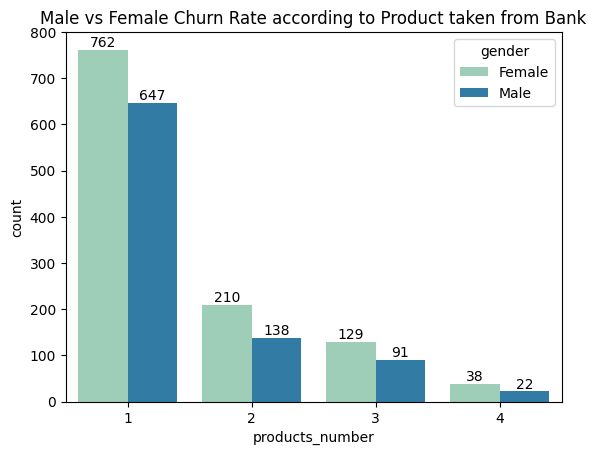

In [ ]:
ax = sns.countplot(data= data_churn,x=data_churn.products_number,hue = data_churn.gender,palette='YlGnBu')
for labels in ax.containers:
  ax.bar_label(labels)
plt.title('Male vs Female Churn Rate according to Product taken from Bank')

Text(0.5, 1.0, 'Male vs Female not churned according to Product taken from Bank')

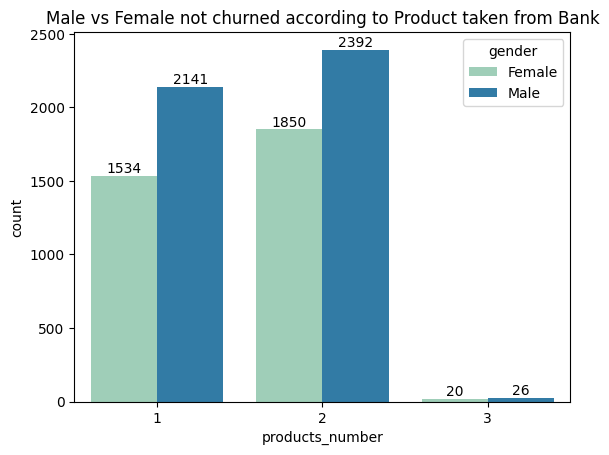

In [ ]:
ax = sns.countplot(data= data_nc,x=data_nc.products_number,hue = data_nc.gender,palette='YlGnBu')
for labels in ax.containers:
  ax.bar_label(labels)
plt.title('Male vs Female not churned according to Product taken from Bank')

Text(0.5, 1.0, 'Active vs Non Avtive member Churned member country wise ')

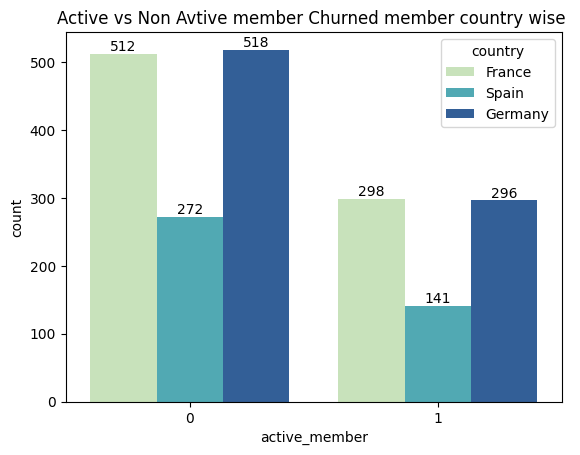

In [ ]:
ax = sns.countplot(data= data_churn,x=data_churn.active_member,hue = data_churn.country,palette='YlGnBu')
for labels in ax.containers:
  ax.bar_label(labels)
plt.title('Active vs Non Avtive member Churned member country wise ')

So we were able to find out these insights from the data:<br>
1. A Female Customer is more likely to churn.
2. Churn Rate is highest in Germany.
3. Customers with more than 3 products from bank have churned according to our data.
4. Credit card is not a factor in deciding the churn of a customer.

### Let's start preparing the data for classification algorithms

In [ ]:
df.drop(['customer_id'],axis=1,inplace=True)

Separation of data into dependent and independent variables

In [ ]:
X = df.drop(['churn'],axis=1)
y = df.churn

In [ ]:
X

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,France,Female,42,2,0.00,1,1,1,101348.88
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58
2,502,France,Female,42,8,159660.80,3,1,0,113931.57
3,699,France,Female,39,1,0.00,2,0,0,93826.63
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,France,Male,39,5,0.00,2,1,0,96270.64
9996,516,France,Male,35,10,57369.61,1,1,1,101699.77
9997,709,France,Female,36,7,0.00,1,0,1,42085.58
9998,772,Germany,Male,42,3,75075.31,2,1,0,92888.52


In [ ]:
X.dtypes

credit_score          int64
country              object
gender               object
age                   int64
tenure                int64
balance             float64
products_number       int64
credit_card           int64
active_member         int64
estimated_salary    float64
dtype: object

In [ ]:
le = LabelEncoder()

In [ ]:
X['gender'] = le.fit_transform(X['gender'])

In [ ]:
X.gender.value_counts()

1    5457
0    4543
Name: gender, dtype: int64

In [ ]:
df.gender.value_counts()

Male      5457
Female    4543
Name: gender, dtype: int64

Hence 0 represents Female and 1 represents Male

In [ ]:
X['country'] = le.fit_transform(X['country'])

In [ ]:
X

,credit_score,country,gender,age,tenure,balance,products_number,credit_card,active_member,estimated_salary
0,619,0,0,42,2,0.00,1,1,1,101348.88
1,608,2,0,41,1,83807.86,1,0,1,112542.58
2,502,0,0,42,8,159660.80,3,1,0,113931.57
3,699,0,0,39,1,0.00,2,0,0,93826.63
4,850,2,0,43,2,125510.82,1,1,1,79084.10
...,...,...,...,...,...,...,...,...,...,...
9995,771,0,1,39,5,0.00,2,1,0,96270.64
9996,516,0,1,35,10,57369.61,1,1,1,101699.77
9997,709,0,0,36,7,0.00,1,0,1,42085.58
9998,772,1,1,42,3,75075.31,2,1,0,92888.52


Let's categorize credit score into 4 categories. <br>
1. Exceptional - 800 to 850
2. Good - 700 to less than 800
3. Fair - 600 to less than 700
4. Poor - less than 500

In [ ]:
def cat_score(score):
  if 800<=score<=850:
    return 4
  elif 700<=score<800:
    return 3
  elif 600<=score<700:
    return 2
  else:
    return 1

In [ ]:
X['cat_score'] = X['credit_score'].apply(cat_score)

In [ ]:
X.drop(['credit_score'],axis=1,inplace=True)

In [ ]:
X['products_number'] = X['products_number'].astype('float64')
X['age'] = X['age'].astype('float64')
X['tenure'] = X['tenure'].astype('float64')

In [ ]:
categorical_features_indices = np.where(X.dtypes != np.float)[0]

<ipython-input-44-65eb6c95badc>:1: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features_indices = np.where(X.dtypes != np.float)[0]


In [ ]:
categorical_features_indices

array([0, 1, 6, 7, 9])

Now to handle the imbalance of our dataset we will use adaptive synthetic oversampling technique. <br>
We have tried our algorithms on the imbalanced and undersampled datasets as well but were able to achieve only 0.49 precision score.

In [ ]:
out_sample = ADASYN(random_state=42)

In [ ]:
X_out, y_out = out_sample.fit_resample(X,y)

In [ ]:
n_splits=10

We have used StratifiedKFold to maintain the class balance in each of the folds.

In [ ]:
kfold = StratifiedKFold(n_splits = n_splits, shuffle = True, random_state = 11)

Now we will use Xgboost Classifier, which was the best amongst other algorithms as we have checked in our prototype version

In [ ]:
xgbc = XGBClassifier(scale_pos_weight = 1,eval_metric='logloss',max_depth=4,learning_rate=0.5)

In [ ]:
fold=0
scores_p=[]
scores_r = []
scores_cks = []
scores_roc_auc = []

In [ ]:
for train_idx,val_idx in kfold.split(X_out,y_out):
  df_train = X_out.iloc[train_idx]
  df_val = X_out.iloc[val_idx]

  y_train = y_out.iloc[train_idx]
  y_test = y_out.iloc[val_idx]
  xgbc.fit(df_train,y_train)
  pred_xgbc_f = xgbc.predict(df_val)
  scores_p.append(precision_score(y_test,pred_xgbc_f))
  scores_r.append(recall_score(y_test,pred_xgbc_f))
  scores_roc_auc.append(roc_auc_score(y_test,pred_xgbc_f))
  scores_cks.append(cohen_kappa_score(y_test,pred_xgbc_f))
  fold+=1

In [ ]:
np.mean(scores_p)

0.9332745076232308

In [ ]:
np.mean(scores_r)

0.8763994060641981

In [ ]:
np.mean(scores_roc_auc)

0.9068063025289561

In [ ]:
np.mean(scores_cks)

0.8135900174582684

Hence we are getting good scores for our model.